### **Import Libraries & Load Data**

In [ ]:
# Imports and dataset paths
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
import time
import json

# NIH Dataset paths
train_dir = "/content/drive/MyDrive/NIH_processed/train"
test_dir = "/content/drive/MyDrive/NIH_processed/test"

# -------------------------------------------------------------------------
# Check class imbalance
# -------------------------------------------------------------------------
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("NIH Dataset Class Distribution:")
check_class_imbalance(train_dir)
check_class_imbalance(test_dir)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# 1 Split into train, val, test (validation split from training directory)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


In [ ]:
# Calculate class weights
labels_array = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_array),
    y=labels_array
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6537162162162162), 1: np.float64(2.1263736263736264)}


#### **Build Model**

In [ ]:
# 3 Load and freeze DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

#### **Compile and Train Model**

In [ ]:
# Compile and train
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

BASE_PATH = "/content/drive/MyDrive/NIH_processed/New_NIH_Models"
best_model_path = os.path.join(BASE_PATH, 'DenseNet121_Best.h5')
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

start_time = time.time()

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Training took {training_time:.2f} minutes")

# Save the training history to a JSON file so you can reload it later
history_path = os.path.join(BASE_PATH, 'densenet121_history.json')
with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to: {history_path}")

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.6034 - loss: 0.7157 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.62666, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/DenseNet121_Best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 3961s 30s/step - accuracy: 0.6036 - loss: 0.7154 - val_accuracy: 0.6679 - val_loss: 0.6267
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6486 - loss: 0.6238
Epoch 2: val_loss improved from 0.62666 to 0.58459, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/DenseNet121_Best.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.6486 - loss: 0.6238 - val_accuracy: 0.6971 - val_loss: 0.5846
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6798 - loss: 0.6049
Epoch 3: val_loss did not improve from 0.58459
134/134 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6797 - loss: 0.6050 - val_accuracy: 0.6453 - val_loss: 0.6478
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6828 - loss: 0.5903
Epoch 4: val_loss did not improve from 0.58459
134/134 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.6828 - loss: 0.5904 - val_accuracy: 0.6670 - val_loss: 0.6335
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6551 - loss: 0.6019
Epoch 5: val_loss did not improve from 0.58459
134/134 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6553 - loss: 0.6018 - val_accuracy: 0.6924 - val_loss: 0.6000
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6866 - loss: 0.5916
Epoch 6: val_loss did not improve from 0.58459


### **Evaluation**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded best model from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/DenseNet121_Best.h5
Size of best model (on disk): 31.12 MB
56/56 ━━━━━━━━━━━━━━━━━━━━ 1251s 23s/step - accuracy: 0.7498 - loss: 0.5216
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step

Baseline DenseNet121 Results:
Test Loss: 0.5613
Accuracy: 0.7169
Precision: 0.5059
Recall: 0.5820
F1-score: 0.5413
AUROC: 0.7447


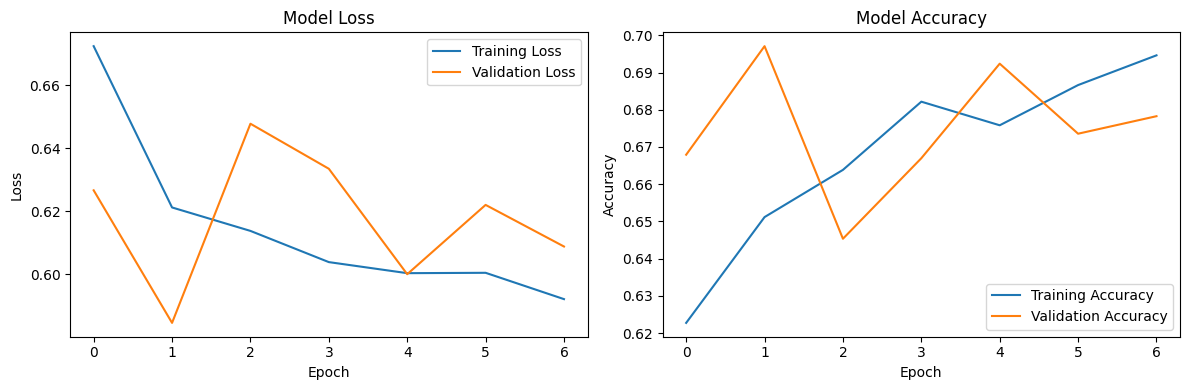

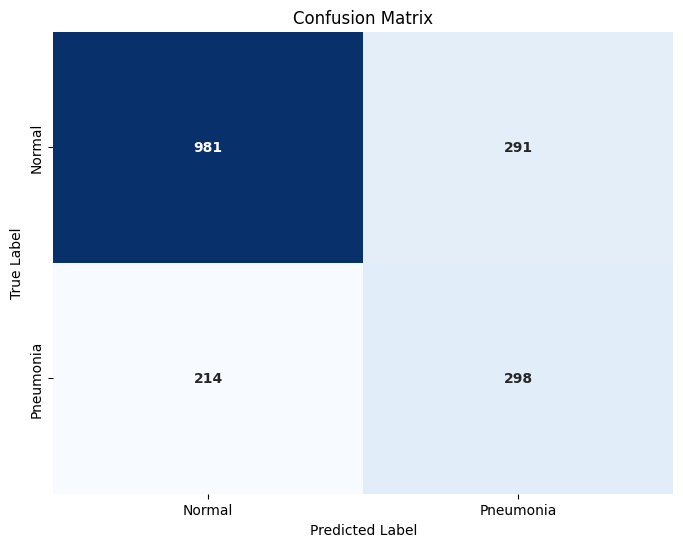

In [ ]:
# Load the best‐saved DenseNet-121 model before evaluation
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

BASE_PATH = "/content/drive/MyDrive/NIH_processed/New_NIH_Models"
best_model_path = os.path.join(BASE_PATH, 'DenseNet121_Best.h5')

model = tf.keras.models.load_model(best_model_path)

# Check size of the loaded model file
best_size_mb = os.path.getsize(best_model_path) / (1024 ** 2)
print(f"Loaded best model from: {best_model_path}")
print(f"Size of best model (on disk): {best_size_mb:.2f} MB")

# Evaluate on the test set using the best weights
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
y_pred = model.predict(test_gen, verbose=1)
y_true = test_gen.labels

# Binarise predictions with threshold 0.50
y_pred_binary = (y_pred > 0.50).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision_val = precision_score(y_true, y_pred_binary)
recall_val = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
auroc = roc_auc_score(y_true, y_pred)

# Save results to CSV
results = {
    'Model': 'DenseNet121',
    'Test Loss': test_loss,
    'Accuracy': accuracy,
    'Precision': precision_val,
    'Recall': recall_val,
    'F1-score': f1,
    'AUROC': auroc,
}
pd.DataFrame([results]).to_csv(
    os.path.join(BASE_PATH, 'densenet121_baseline_results.csv'),
    index=False
)

print("\nBaseline DenseNet121 Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")

# Load the saved training history from JSON for plotting
history_path = os.path.join(BASE_PATH, 'densenet121_history.json')
with open(history_path, 'r') as f:
    history_dict = json.load(f)

# Plot training history for loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute and visualise the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={'fontweight': 'bold'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0.5, 1.5], labels=["Normal", "Pneumonia"])
plt.yticks(ticks=[0.5, 1.5], labels=["Normal", "Pneumonia"])
plt.show()

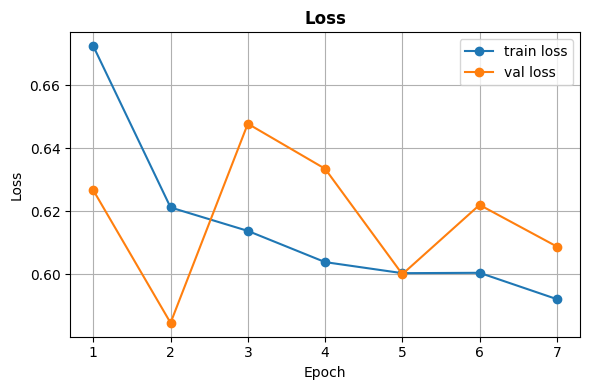

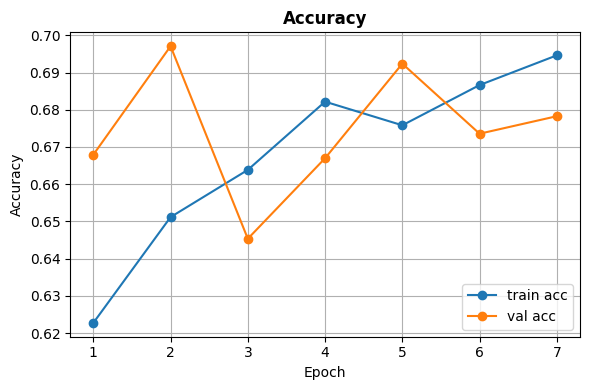

In [ ]:
# Extract history values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, marker='o', label='train loss')
plt.plot(epochs, val_loss, marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, marker='o', label='train acc')
plt.plot(epochs, val_acc, marker='o', label='val acc')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Evaluation (Enhanced Visual**)


Classification Report:

              precision    recall  f1-score   support

      normal     0.8209    0.7712    0.7953      1272
   pneumonia     0.5059    0.5820    0.5413       512

    accuracy                         0.7169      1784
   macro avg     0.6634    0.6766    0.6683      1784
weighted avg     0.7305    0.7169    0.7224      1784



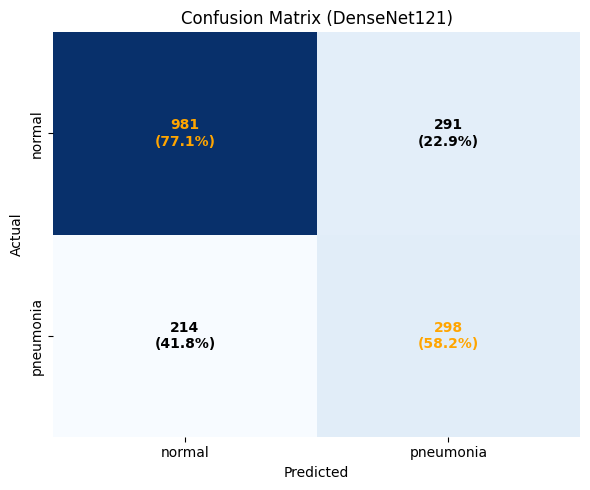

In [ ]:
# Print the classification report
target_names = list(test_gen.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_binary, target_names=target_names, digits=4))

# Compute confusion matrix (counts + row-wise %)
cm = confusion_matrix(y_true, y_pred_binary)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues', cbar=False,
    xticklabels=target_names,
    yticklabels=target_names
)

# Annotate each cell with “count\n(percentage%)”
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct   = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold' # Added fontweight='bold' here
        )

plt.title("Confusion Matrix (DenseNet121)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

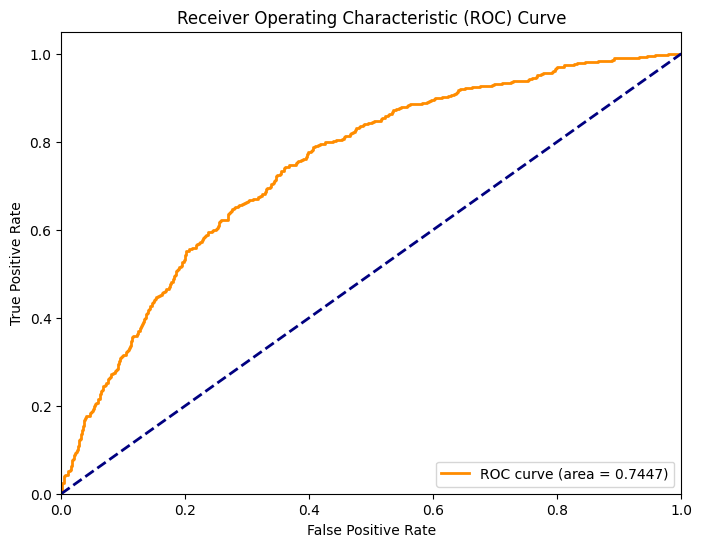

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()